### Objetivo: Construir um bom modelo Regressor

In [1]:
# !pip install -q -U watermark

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.power import TTestIndPower
from scipy import stats

import pickle

import warnings
warnings.filterwarnings("ignore")

In [3]:
%reload_ext watermark
%watermark -a "Modelo Regressor"
%watermark --iversions

Author: Modelo Regressor

statsmodels: 0.13.2
scipy      : 1.13.1
pandas     : 2.2.3
seaborn    : 0.13.2
matplotlib : 3.9.2
sklearn    : 1.6.0
numpy      : 1.26.4



#### Dicionário de Dados: 
- mpg	- Milhas/galão
- cyl	- Número de cilindros
- disp	- Deslocamento
- hp	- Horsepower (cavalos de potência)
- drat	- Relação do eixo traseiro
- wt	- Peso (1000 lbs)
- qsec	- 1/4 mile time (tempo que leva para percorrer 1/4 de milha)
- vs	- Motor (0 = turbo, 1 = normal)
- am	- Transmissão (0 = automática, 1 = manual)
- gear	- Número de engrenagens
- carb	- Número de carburadores


Quinlan, R. (1993). Auto MPG [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5859H.

In [4]:
df_mtcars = sm.datasets.get_rdataset("mtcars", "datasets", cache=True).data
df_mtcars.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
rownames,,,,,,,,,,,
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [5]:
df_mtcars.mpg.describe()

count    32.000000
mean     20.090625
std       6.026948
min      10.400000
25%      15.425000
50%      19.200000
75%      22.800000
max      33.900000
Name: mpg, dtype: float64

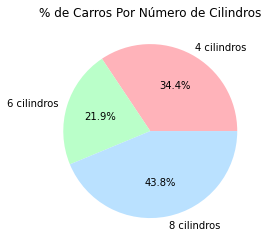

In [6]:
cyl_freq = df_mtcars['cyl'].value_counts().sort_index()

labels = [f"{label} cilindros" for label in cyl_freq.index]

colors = ['#FFB3BA', '#BAFFC9', '#BAE1FF']

plt.pie(cyl_freq, labels=labels, colors=colors[:len(labels)], autopct='%1.1f%%')
plt.title("% de Carros Por Número de Cilindros")
plt.show()

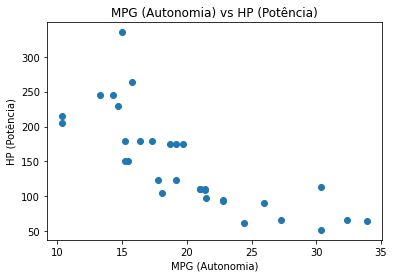

In [7]:
# Scatter Plot - MPG vs HP
plt.scatter(df_mtcars['mpg'], df_mtcars['hp'])
plt.title("MPG (Autonomia) vs HP (Potência)")
plt.xlabel("MPG (Autonomia)")
plt.ylabel("HP (Potência)")
plt.show()

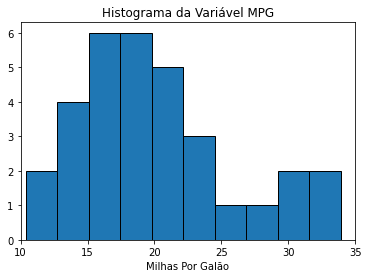

In [8]:
# Histograma da variável MPG
plt.hist(df_mtcars['mpg'], bins=10, edgecolor='black')
plt.xlabel("Milhas Por Galão")
plt.title("Histograma da Variável MPG")
plt.xlim(10, 35)
plt.show()

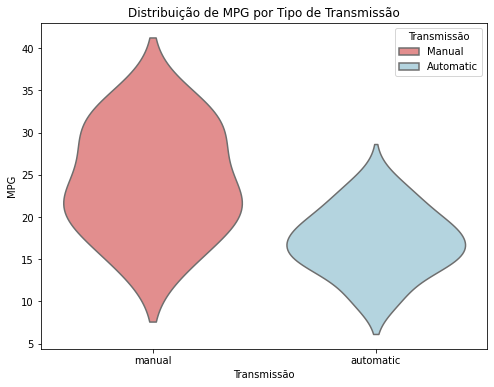

In [9]:
df_mtcars['am_label'] = df_mtcars['am'].map({0: 'automatic', 1: 'manual'})

plt.figure(figsize=(8, 6))
sns.violinplot(x='am_label', y='mpg', data=df_mtcars, hue='am_label', inner=None, linewidth=1.5, palette={'automatic': 'lightblue', 'manual': 'lightcoral'})

plt.xlabel("Transmissão")
plt.ylabel("MPG")
plt.title("Distribuição de MPG por Tipo de Transmissão")
plt.legend(title='Transmissão', loc='upper right', labels=['Manual','Automatic'])
plt.show()

### Welch Test
- H0: as médias são iguais
- H1: as médias são diferentes

In [10]:
mpg_automatic = df_mtcars[df_mtcars['am'] == 0]['mpg']
mpg_manual = df_mtcars[df_mtcars['am'] == 1]['mpg']

t_statistic, p_value = stats.ttest_ind(mpg_automatic, mpg_manual, equal_var=False)

print(f"Estatística t: {t_statistic:.4f}")
print(f"Valor-p: {p_value:.4f}")

Estatística t: -3.7671
Valor-p: 0.0014


#### Interpretação do Teste: Rejeita hipótese nula, as médias são diferentes.

### Shapiro Test para verificar a normalidade
- H0: os dados são normalmente distribuídos
- H1: os dados não são normalmente distribuídos

In [11]:
df_mtcars['am_label'] = df_mtcars['am'].map({0: 'automatic', 1: 'manual'})

mpg_automatic = df_mtcars[df_mtcars['am_label'] == 'automatic']['mpg']
mpg_manual = df_mtcars[df_mtcars['am_label'] == 'manual']['mpg']

shapiro_automatic = stats.shapiro(mpg_automatic)
shapiro_manual = stats.shapiro(mpg_manual)

print("Teste de Shapiro-Wilk para MPG (Automatic):")
print(f"Estatística W: {shapiro_automatic.statistic:.4f}")
print(f"Valor-p: {shapiro_automatic.pvalue:.4f}")

print("\nTeste de Shapiro-Wilk para MPG (Manual):")
print(f"Estatística W: {shapiro_manual.statistic:.4f}")
print(f"Valor-p: {shapiro_manual.pvalue:.4f}")

Teste de Shapiro-Wilk para MPG (Automatic):
Estatística W: 0.9768
Valor-p: 0.8987

Teste de Shapiro-Wilk para MPG (Manual):
Estatística W: 0.9458
Valor-p: 0.5363


#### Interpretação do Teste: ambas as distribuições possuem p-value maior que 0.05, ou seja, não há evidências estatísticas suficientes para rejeitar a hipótese nula para nenhum dos dois tipos de transmissão. Os dados seguem um distribuição normal com o câmbio sendo automático ou não.

### Barlett Test
- H0: variâncias são iguais para todas as amostras
- H1: variâncias não são iguais para todas as amostras

In [12]:
mpg_automatic = df_mtcars[df_mtcars['am_label'] == 'automatic']['mpg']
mpg_manual = df_mtcars[df_mtcars['am_label'] == 'manual']['mpg']


statistic, p_value = stats.bartlett(mpg_automatic, mpg_manual)

print(f"Estatística de Bartlett: {statistic:.4f}")
print(f"Valor-p: {p_value:.4f}")

Estatística de Bartlett: 3.2259
Valor-p: 0.0725


#### Interpretação do Teste: não rejeitamos a hipótese nula e podemos assumir que as variâncias são iguais para todas as amostras. Ambas as suposições são verdadeiras e o teste inicial foi validado com sucesso.

### Student - Desta vez sabendo que as variâncias são iguais devidamente validadas
Os pressupostos foram atendidos: distribuições normais e variâncias iguais

In [13]:
t_statistic, p_value = stats.ttest_ind(mpg_automatic, mpg_manual, equal_var=True)

print(f"Estatística t: {t_statistic:.4f}")
print(f"Valor-p: {p_value:.4f}")

Estatística t: -4.1061
Valor-p: 0.0003


#### Interpretação do Teste: o consumo de combustível é diferente de acordo com o tipo de câmbio. Mas qual é a força desse teste?

In [14]:
counts = df_mtcars['am_label'].value_counts()
counts

am_label
automatic    19
manual       13
Name: count, dtype: int64

In [58]:
nobs1 = counts['automatic']
nobs2 = counts['manual']
effect_size = abs(t_statistic) / ((1/nobs1 + 1/nobs2)**0.5)  # Converte t para d de Cohen
alpha = 0.05

power_analysis = TTestIndPower()

power = power_analysis.power(
                             effect_size=effect_size,
                             nobs1=nobs1,
                             ratio=nobs2/nobs1,
                             alpha=alpha,
                             alternative='two-sided'
                            )


print(f"Power do teste: {power:.4f}")

Power do teste: 1.0000


##### Interpretação do resultado final: agora posso afirmar que as médias realmente são diferentes e não apenas fruto do acaso. A transmissão manual é diferente da transmissão automática no consumo de combustível

### Forma visual

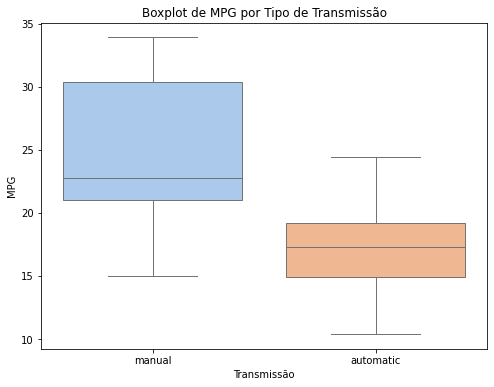

In [16]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='am_label', y='mpg', data=df_mtcars, palette='pastel', hue=None)

plt.xlabel('Transmissão')
plt.ylabel('MPG')
plt.title('Boxplot de MPG por Tipo de Transmissão')
plt.show()

## Será que há modelo?
Vamos usar mínimos quadrados (OLS)
![OLS](img/ols.png)
Imagem de exemplo retirado de https://dataat.github.io/introducao-ao-machine-learning/regress%C3%A3o.html

$$
y_i = \beta_0 + \beta_1 x_i + \epsilon_i
$$

$$
y_i: \quad \text{Valor observado da variável dependente}
$$

$$
\beta_0: \quad \text{Intercepto (constante)}
$$

$$
\beta_1: \quad \text{Coeficiente angular (inclinação da reta)}
$$

$$
x_i: \quad \text{Valor observado da variável independente}
$$

$$
\epsilon_i: \quad \text{Erro (resíduo/epsilon) da observação } i
$$

$$
\beta = \frac{ \sum (x_i y_i) - n \bar{x} \bar{y} }{ \sum (x_i^2) - n \bar{x}^2 }
$$

### Modelo 1

In [17]:
X = df_mtcars['am']
y = df_mtcars['mpg']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     16.86
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           0.000285
Time:                        23:55:04   Log-Likelihood:                -95.242
No. Observations:                  32   AIC:                             194.5
Df Residuals:                      30   BIC:                             197.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.1474      1.125     15.247      0.0

In [18]:
# Avaliação da significância da variável
# Quando aparecer com * terá significância
def format_significance(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    elif p_value < 0.1:
        return '.'
    else:
        return ''

print("\nCoeficientes com Significância:")
for i, (coef, p_val) in enumerate(zip(model.params, model.pvalues)):
    significance = format_significance(p_val)
    print(f"{model.params.index[i]}: {coef:.4f} {significance}")


Coeficientes com Significância:
const: 17.1474 ***
am: 7.2449 ***


Câmbio como variável categórica

In [19]:
df_mtcars['am'] = df_mtcars['am'].astype('category')
model = smf.ols('mpg ~ C(am)', data=df_mtcars).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     16.86
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           0.000285
Time:                        23:55:04   Log-Likelihood:                -95.242
No. Observations:                  32   AIC:                             194.5
Df Residuals:                      30   BIC:                             197.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.1474      1.125     15.247      0.0

### Modelo 2
#### Avaliação de todas as variáveis para ver se são estatisticamente significantes
Apenas para efeitos didáticos

In [20]:
df_mtcars['vs'] = df_mtcars['vs'].astype('category')
df_mtcars['am'] = df_mtcars['am'].astype('category')

model2 = smf.ols('mpg ~ cyl + disp + hp + drat + wt + qsec + C(vs) + C(am) + gear + carb', data=df_mtcars).fit()

print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     13.93
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           3.79e-07
Time:                        23:55:05   Log-Likelihood:                -69.855
No. Observations:                  32   AIC:                             161.7
Df Residuals:                      21   BIC:                             177.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3034     18.718      0.657      0.5

In [21]:
print("\nCoeficientes com Significância:")
for i, (coef, p_val) in enumerate(zip(model2.params, model2.pvalues)):
    significance = format_significance(p_val)
    print(f"{model2.params.index[i]}: {coef:.4f} {significance}")


Coeficientes com Significância:
Intercept: 12.3034 
C(vs)[T.1]: 0.3178 
C(am)[T.1]: 2.5202 
cyl: -0.1114 
disp: 0.0133 
hp: -0.0215 
drat: 0.7871 
wt: -3.7153 .
qsec: 0.8210 
gear: 0.6554 
carb: -0.1994 


### Avaliação da multicolinearidade com Fator de Inflação da Variância
#### Mede quanto a variância do coeficiente de uma variável está inflada por causa da correlação com outras variáveis.


$$
\text{VIF}(X_i) = \frac{1}{1 - R^2_i}
$$




onde:

- \( R^2_i \) = o \( R^2 \) da regressão de \( X_i \) contra todas as outras variáveis.

Então:

- Se \( R^2_i \) for alto: a variável é muito explicada pelas outras, o VIF vai ser alto.
- Se \( R^2_i \) for baixo: a variável é independente das outras, o VIF será próximo de 1.

- VIF < 5: Geralmente indica baixa multicolinearidade. As variáveis não estão altamente correlacionadas entre si.
- 5 ≤ VIF < 10: Indica uma quantidade moderada de multicolinearidade. As variáveis têm alguma correlação, mas não é extremamente alta.
- VIF ≥ 10: Indica alta multicolinearidade. As variáveis estão altamente correlacionadas entre si, o que pode afetar a estabilidade e a interpretabilidade do modelo.

In [22]:
X = df_mtcars[['cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am', 'gear', 'carb']]
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.to_markdown(index=False, tablefmt='pipe'))

| Variable   |        VIF |
|:-----------|-----------:|
| const      | 1596.27    |
| cyl        |   15.3738  |
| disp       |   21.6202  |
| hp         |    9.83204 |
| drat       |    3.37462 |
| wt         |   15.1649  |
| qsec       |    7.52796 |
| vs         |    4.96587 |
| am         |    4.64849 |
| gear       |    5.35745 |
| carb       |    7.90875 |


### Modelo 3
#### Vamos obter as melhores variáveis para o modelo

In [23]:
cols = ['cyl', 'hp', 'drat', 'wt', 'qsec', 'C(vs)', 'C(am)', 'gear', 'carb']
formula = 'mpg ~ ' + ' + '.join(cols)

model3 = smf.ols(formula=formula, data=df_mtcars).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     15.73
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           1.18e-07
Time:                        23:55:05   Log-Likelihood:                -70.274
No. Observations:                  32   AIC:                             160.5
Df Residuals:                      22   BIC:                             175.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.5505     18.526      0.677      0.5

In [24]:
print("\nCoeficientes com Significância:")
for i, (coef, p_val) in enumerate(zip(model3.params, model3.pvalues)):
    significance = format_significance(p_val)
    print(f"{model3.params.index[i]}: {coef:.4f} {significance}")


Coeficientes com Significância:
Intercept: 12.5505 
C(vs)[T.1]: 0.1604 
C(am)[T.1]: 2.4788 
cyl: 0.0963 
hp: -0.0129 
drat: 0.9286 
wt: -2.6269 *
qsec: 0.6652 
gear: 0.7430 
carb: -0.6169 


In [25]:
# Passei os nomes de novo para pegar os nomes originais das colunas
cols = ['cyl', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am', 'gear', 'carb']
X = df_mtcars[cols]
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.to_markdown(index=False, tablefmt='pipe'))

| Variable   |        VIF |
|:-----------|-----------:|
| const      | 1595.77    |
| cyl        |   14.2847  |
| hp         |    7.12336 |
| drat       |    3.3293  |
| wt         |    6.18905 |
| qsec       |    6.91442 |
| vs         |    4.91605 |
| am         |    4.64511 |
| gear       |    5.3244  |
| carb       |    4.3106  |


### Modelo 4

In [26]:
cols = ['hp', 'drat', 'wt', 'qsec', 'C(vs)', 'C(am)', 'gear', 'carb']
formula = 'mpg ~ ' + ' + '.join(cols)

model4 = smf.ols(formula=formula, data=df_mtcars).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     18.50
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           2.63e-08
Time:                        23:55:05   Log-Likelihood:                -70.281
No. Observations:                  32   AIC:                             158.6
Df Residuals:                      23   BIC:                             171.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.8081     12.886      1.072      0.2

In [27]:
print("\nCoeficientes com Significância em Ordem Decrescente:")
resultados = []

for i, (coef, p_val) in enumerate(zip(model4.params, model4.pvalues)):
    resultados.append((model4.params.index[i], coef, p_val, format_significance(p_val)))

resultados_ordenados = sorted(resultados, key=lambda x: x[2])

for nome, coef, p_val, signif in resultados_ordenados:
    print(f"{nome}: {coef:.4f} {signif}")


Coeficientes com Significância em Ordem Decrescente:
wt: -2.6097 *
C(am)[T.1]: 2.4242 
Intercept: 13.8081 
carb: -0.6129 
qsec: 0.6398 
hp: -0.0123 
drat: 0.8889 
gear: 0.6939 
C(vs)[T.1]: 0.0879 


In [28]:
cols = ['hp', 'drat', 'wt', 'qsec', 'vs', 'am', 'gear', 'carb']
X = df_mtcars[cols]
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.to_markdown(index=False, tablefmt='pipe'))

| Variable   |       VIF |
|:-----------|----------:|
| const      | 806.789   |
| hp         |   6.01579 |
| drat       |   3.1115  |
| wt         |   6.05113 |
| qsec       |   5.91868 |
| vs         |   4.27096 |
| am         |   4.28581 |
| gear       |   4.69019 |
| carb       |   4.29047 |


#### OBS: Variâncias inflacionadas removidas. Agora vamos reduzir a complexidade do modelo.

### Modelo 5
Continua explicando a mesma variabilidade dos dados removendo uma variável, ou seja, está melhor

In [29]:
cols = ['hp', 'drat', 'wt', 'qsec', 'C(am)', 'gear', 'carb']
formula = 'mpg ~ ' + ' + '.join(cols)

model5 = smf.ols(formula=formula, data=df_mtcars).fit()
print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     22.06
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           5.31e-09
Time:                        23:55:05   Log-Likelihood:                -70.283
No. Observations:                  32   AIC:                             156.6
Df Residuals:                      24   BIC:                             168.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.4921     10.718      1.259      0.2

In [30]:
print("\nCoeficientes com Significância em Ordem Decrescente:")
resultados = []

for i, (coef, p_val) in enumerate(zip(model5.params, model5.pvalues)):
    resultados.append((model5.params.index[i], coef, p_val, format_significance(p_val)))

resultados_ordenados = sorted(resultados, key=lambda x: x[2])

for nome, coef, p_val, signif in resultados_ordenados:
    print(f"{nome}: {coef:.4f} {signif}")


Coeficientes com Significância em Ordem Decrescente:
wt: -2.6277 *
qsec: 0.6585 
C(am)[T.1]: 2.4135 
Intercept: 13.4921 
carb: -0.6146 
hp: -0.0121 
drat: 0.8976 
gear: 0.7055 


### Modelo 6

In [31]:
cols = ['hp', 'drat', 'wt', 'qsec', 'C(am)', 'carb']
formula = 'mpg ~ ' + ' + '.join(cols)

model6 = smf.ols(formula=formula, data=df_mtcars).fit()
print(model6.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     26.43
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           1.12e-09
Time:                        23:55:05   Log-Likelihood:                -70.477
No. Observations:                  32   AIC:                             155.0
Df Residuals:                      25   BIC:                             165.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.5511     10.388      1.401      0.1

In [32]:
print("\nCoeficientes com Significância em Ordem Decrescente:")
resultados = []

for i, (coef, p_val) in enumerate(zip(model6.params, model6.pvalues)):
    resultados.append((model6.params.index[i], coef, p_val, format_significance(p_val)))

resultados_ordenados = sorted(resultados, key=lambda x: x[2])

for nome, coef, p_val, signif in resultados_ordenados:
    print(f"{nome}: {coef:.4f} {signif}")


Coeficientes com Significância em Ordem Decrescente:
wt: -2.8290 **
C(am)[T.1]: 2.8586 .
qsec: 0.7071 
Intercept: 14.5511 
carb: -0.4544 
drat: 1.0728 
hp: -0.0117 


### Modelo 7

In [33]:
cols = ['drat', 'wt', 'qsec', 'C(am)', 'carb']
formula = 'mpg ~ ' + ' + '.join(cols)

model7 = smf.ols(formula=formula, data=df_mtcars).fit()
print(model7.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     32.15
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           2.42e-10
Time:                        23:55:05   Log-Likelihood:                -70.829
No. Observations:                  32   AIC:                             153.7
Df Residuals:                      26   BIC:                             162.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.9243      8.259      1.202      0.2

In [34]:
print("\nCoeficientes com Significância em Ordem Decrescente:")
resultados = []

for i, (coef, p_val) in enumerate(zip(model7.params, model7.pvalues)):
    resultados.append((model7.params.index[i], coef, p_val, format_significance(p_val)))

resultados_ordenados = sorted(resultados, key=lambda x: x[2])

for nome, coef, p_val, signif in resultados_ordenados:
    print(f"{nome}: {coef:.4f} {signif}")


Coeficientes com Significância em Ordem Decrescente:
wt: -3.1108 **
qsec: 0.9145 *
C(am)[T.1]: 2.9639 .
carb: -0.6023 
Intercept: 9.9243 
drat: 1.2071 


### Modelo 8

In [35]:
cols = ['wt', 'qsec', 'C(am)', 'carb']
formula = 'mpg ~ ' + ' + '.join(cols)

model8 = smf.ols(formula=formula, data=df_mtcars).fit()
print(model8.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     40.39
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           5.06e-11
Time:                        23:55:05   Log-Likelihood:                -71.282
No. Observations:                  32   AIC:                             152.6
Df Residuals:                      27   BIC:                             159.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.8972      7.472      1.726      0.0

In [36]:
print("\nCoeficientes com Significância em Ordem Decrescente:")
resultados = []

for i, (coef, p_val) in enumerate(zip(model8.params, model8.pvalues)):
    resultados.append((model8.params.index[i], coef, p_val, format_significance(p_val)))

resultados_ordenados = sorted(resultados, key=lambda x: x[2])

for nome, coef, p_val, signif in resultados_ordenados:
    print(f"{nome}: {coef:.4f} {signif}")


Coeficientes com Significância em Ordem Decrescente:
wt: -3.4343 ***
qsec: 1.0191 **
C(am)[T.1]: 3.5114 *
Intercept: 12.8972 .
carb: -0.4886 


### Modelo 9

In [37]:
cols = ['wt', 'qsec', 'C(am)']
formula = 'mpg ~ ' + ' + '.join(cols)

model9 = smf.ols(formula=formula, data=df_mtcars).fit()
print(model9.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     52.75
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           1.21e-11
Time:                        23:55:05   Log-Likelihood:                -72.060
No. Observations:                  32   AIC:                             152.1
Df Residuals:                      28   BIC:                             158.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.6178      6.960      1.382      0.1

In [38]:
print("\nCoeficientes com Significância em Ordem Decrescente:")
resultados = []

for i, (coef, p_val) in enumerate(zip(model9.params, model9.pvalues)):
    resultados.append((model9.params.index[i], coef, p_val, format_significance(p_val)))

resultados_ordenados = sorted(resultados, key=lambda x: x[2])

for nome, coef, p_val, signif in resultados_ordenados:
    print(f"{nome}: {coef:.4f} {signif}")


Coeficientes com Significância em Ordem Decrescente:
wt: -3.9165 ***
qsec: 1.2259 ***
C(am)[T.1]: 2.9358 *
Intercept: 9.6178 


### Modelo 10

In [39]:
cols = ['wt', 'qsec']
formula = 'mpg ~ ' + ' + '.join(cols)

model10 = smf.ols(formula=formula, data=df_mtcars).fit()
print(model10.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     69.03
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           9.39e-12
Time:                        23:55:05   Log-Likelihood:                -74.360
No. Observations:                  32   AIC:                             154.7
Df Residuals:                      29   BIC:                             159.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.7462      5.252      3.760      0.0

In [40]:
print("\nCoeficientes com Significância em Ordem Decrescente:")
resultados = []

for i, (coef, p_val) in enumerate(zip(model10.params, model10.pvalues)):
    resultados.append((model10.params.index[i], coef, p_val, format_significance(p_val)))

resultados_ordenados = sorted(resultados, key=lambda x: x[2])

for nome, coef, p_val, signif in resultados_ordenados:
    print(f"{nome}: {coef:.4f} {signif}")


Coeficientes com Significância em Ordem Decrescente:
wt: -5.0480 ***
Intercept: 19.7462 ***
qsec: 0.9292 **


### Melhor Modelo
O Modelo 9 apresentou o melhor resultado pelo nível de significância dos coeficientes, p-values e também da explicabilidade do modelo para identificar o padrão da relação entre as variáveis independentes(X) e a dependente(Y).

### Construção de Modelos com melhores capacidades preditivas

In [41]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    mae = mean_absolute_error(y_teste, previsao)
    rsme = np.sqrt(mean_squared_error(y_teste, previsao))    
    return f'Modelo {nome_modelo}:\nR2:{r2:.4}\nMAE:{mae:.4f}\nRSME:{rsme:.4f}\n'

In [42]:
parametros = {
    'RandomForest': {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 5, 10, 20]
    },
    'LinearRegression': {},
    'ExtraTrees': {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 5, 10, 20]
    },
    'KNN': {
        'n_neighbors': [2, 3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    }
}

In [43]:
modelo_randomforest = RandomForestRegressor()
modelo_linearregression = LinearRegression()
modelo_extratrees = ExtraTreesRegressor()
modelo_knn = KNeighborsRegressor()

In [44]:
modelos = {
           'RandomForest': modelo_randomforest,
           'LinearRegression': modelo_linearregression,
           'ExtraTrees': modelo_extratrees,
           'KNN':modelo_knn
          }

X = df_mtcars[['qsec', 'wt', 'am']]
y = df_mtcars['mpg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [46]:
resultados = []

for nome_modelo, modelo in modelos.items():
    if parametros[nome_modelo]:
        random_search = RandomizedSearchCV(modelo, parametros[nome_modelo], n_iter=5, cv=3, random_state=42, scoring='neg_mean_squared_error')
        random_search.fit(X_train_scaled, y_train)
        melhor_modelo = random_search.best_estimator_
        melhores_parametros = random_search.best_params_
    else:
        melhor_modelo = modelo.fit(X_train_scaled, y_train)
        melhores_parametros = {}

    previsao = melhor_modelo.predict(X_test_scaled)
    r2 = r2_score(y_test, previsao)
    mae = mean_absolute_error(y_test, previsao)
    rmse = np.sqrt(mean_squared_error(y_test, previsao))
    
    resultados.append({
        'Modelo': nome_modelo,
        'R2': round(r2, 4),
        'MAE': round(mae, 4),
        'RMSE': round(rmse, 4)
    })
    
    with open(f'models/{nome_modelo}.pkl', 'wb') as f:
        pickle.dump(melhor_modelo, f)

df_resultados = pd.DataFrame(resultados).sort_values(by='R2', ascending=False).reset_index(drop=True)

In [47]:
df_resultados

,Modelo,R2,MAE,RMSE
0,KNN,0.8522,2.3071,2.4310
1,LinearRegression,0.8322,2.0214,2.5905
2,RandomForest,0.7504,2.2873,3.1594
3,ExtraTrees,0.7432,2.5073,3.2042


### Previsão com Novos Dados

In [49]:
# Salvando a seleção de variáveis
variaveis_usadas = ['qsec', 'wt', 'am']

with open('models/feature_selection.pkl', 'wb') as f:
    pickle.dump(variaveis_usadas, f)
    
    
# Salvando o pré-processamento    
with open('models/preprocessamento.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [50]:
# Carregando os modelos
with open('models/feature_selection.pkl', 'rb') as f:
    variaveis_usadas = pickle.load(f)
    
with open('models/preprocessamento.pkl', 'rb') as f:
    scaler = pickle.load(f)
    
with open('models/KNN.pkl', 'rb') as f:
    modelo_knn_carregado = pickle.load(f)

### Novos dados entraram na base

In [51]:
novos_carros = pd.DataFrame({
    'cyl': [6, 4, 8],
    'disp': [70.0, 200.0, 450.0],
    'hp': [50, 150, 300],
    'drat': [4.5, 3.2, 2.8],
    'wt': [1.8, 3.2, 5.0],
    'qsec': [20.5, 17.0, 15.0],
    'vs': [1, 0, 0],
    'am': [1, 0, 0],
    'gear': [5, 4, 3],
    'carb': [1, 4, 6]
}, index=['Carro A', 'Carro B', 'Carro C'])

In [52]:
novos_carros

,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
Carro A,6,70.0,50,4.5,1.8,20.5,1,1,5,1
Carro B,4,200.0,150,3.2,3.2,17.0,0,0,4,4
Carro C,8,450.0,300,2.8,5.0,15.0,0,0,3,6


In [53]:
novo_carro_filtrado = novos_carros[variaveis_usadas]
novo_carro_filtrado

,qsec,wt,am
Carro A,20.5,1.8,1
Carro B,17.0,3.2,0
Carro C,15.0,5.0,0


In [54]:
novo_carro_normalizado = scaler.transform(novo_carro_filtrado)
novo_carro_normalizado

array([[ 1.82445894, -1.40352219,  1.22474487],
       [-0.55894144,  0.06052802, -0.81649658],
       [-1.9208845 ,  1.94287828, -0.81649658]])

In [55]:
previsao_novos_carros = modelo_knn_carregado.predict(novo_carro_normalizado)
previsao_novos_carros

array([30.6 , 16.95, 13.8 ])